In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    hour = 'y-m-d-hour'
    month = 'month'
    status = 'status'

file_list = os.listdir('../Data/data_per_machine/2022/raw/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C609.csv', '15

In [38]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [39]:
mach_index = 0

In [40]:
df = pd.read_csv('../Data/data_per_machine/2022/raw/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
df[ColumnsOutput.hour] = df[ColumnsInput.time].dt.strftime('%y-%m-%d-%H')
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode ddc_mch_code ddc_mch_side               ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day   y-m-d-hour
0       13560   9439791381       23097         C403            R              UN_VACUUM_START 2022-10-11 00:40:46       True     10  22-10-11  22-10-11-00
1      362023   9439791356       23097         C403            R     LO_LOADER_IN_PRESS_START 2022-10-11 19:49:39       True     10  22-10-11  22-10-11-19
2      362024   9439791357       23097         C403            L     LO_LOADER_IN_PRESS_START 2022-10-11 19:49:39       True     10  22-10-11  22-10-11-19
3      362031   9439791356       23097         C403            R      LO_LOADER_IN_PRESS_STOP 2022-10-11 19:49:44       True     10  22-10-11  22-10-11-19
4      362032   9439791356       23097         C403            R  LO_BLADDER_PRESHAPING_START 2022-10-11 19:49:44       True     10  22-10-11  22-10-11-19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300588 entries, 0 to

In [41]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(46, 4)
    y-m-day                 min                 max  work_time
0  22-10-11 2022-10-11 00:40:46 2022-10-11 23:59:59    83953.0
1  22-10-12 2022-10-12 00:00:04 2022-10-12 23:49:15    85751.0
2  22-10-13 2022-10-13 00:04:20 2022-10-13 05:45:56    20496.0
3  22-10-14 2022-10-14 20:11:08 2022-10-14 23:45:25    12857.0
4  22-10-15 2022-10-15 00:00:00 2022-10-15 20:55:47    75347.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-11            L 2022-10-11 19:49:39 2022-10-11 23:59:59    15020.0
1  22-10-11            R 2022-10-11 00:40:46 2022-10-11 23:59:59    83953.0
2  22-10-12            L 2022-10-12 00:00:04 2022-10-12 23:49:15    85751.0
3  22-10-12            R 2022-10-12 00:00:04 2022-10-12 23:49:15    85751.0
4  22-10-13            L 2022-10-13 00:04:20 2022-10-13 05:45:56    20496.0


(46, 5)

In [42]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(46, 2)
(91, 3)


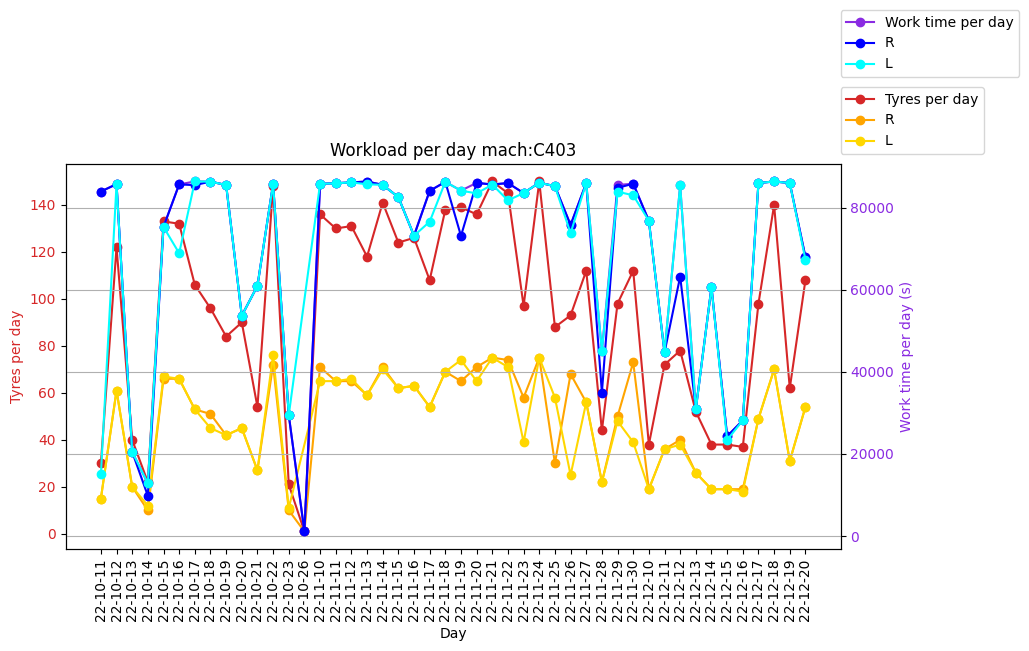

In [43]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title(f'Workload per day mach:{current_machine}')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

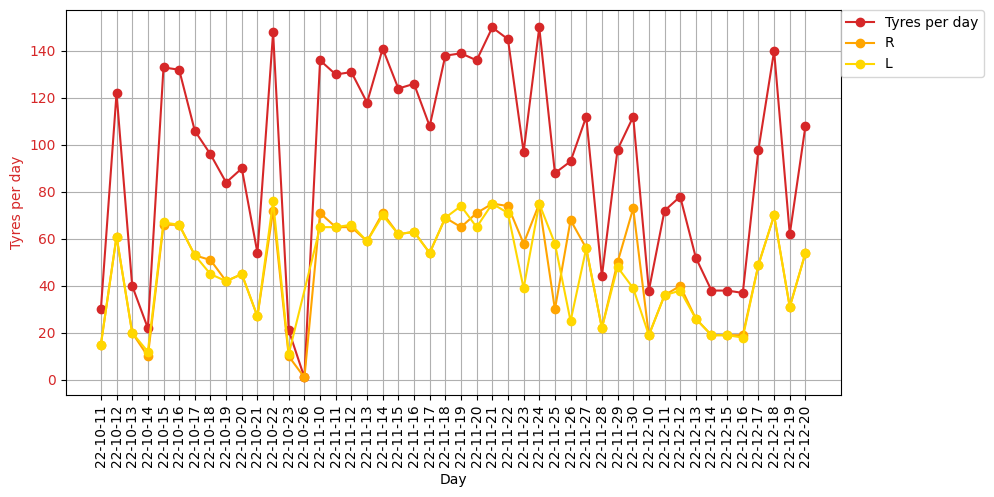

In [44]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

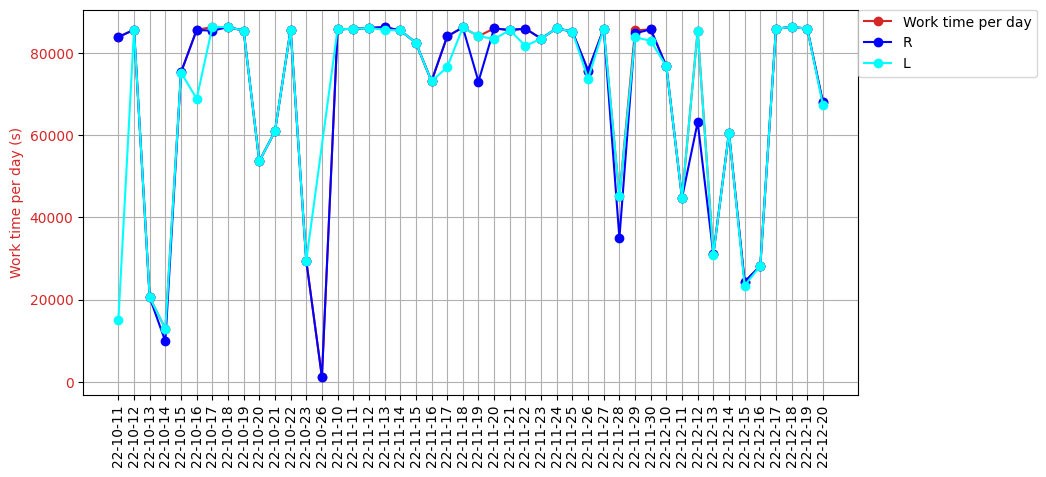

In [45]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [46]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [47]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()
label_for_check_time_loss = label_cycle_status_

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

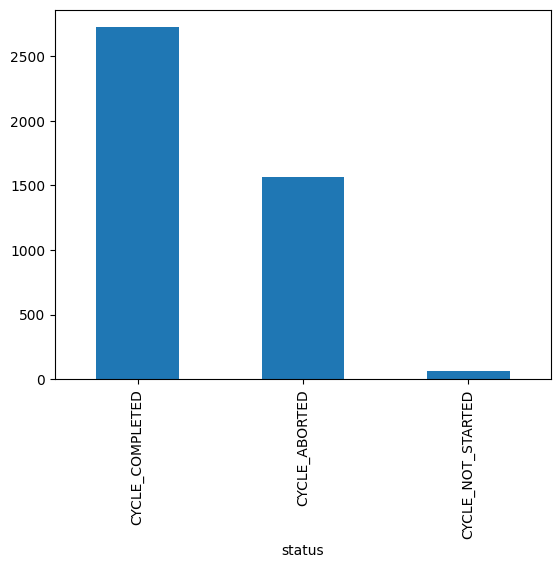

In [48]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

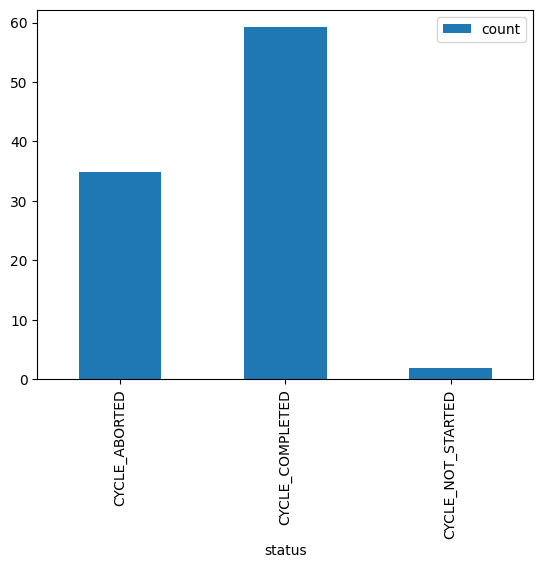

In [49]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [50]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day[status] = 0
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

46
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-11              9               20                  1
1       22-10-12             44               77                  1
2       22-10-13             12               27                  1
3       22-10-14              8               14                  0
4       22-10-15             41               91                  1
(46, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(46, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(46, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


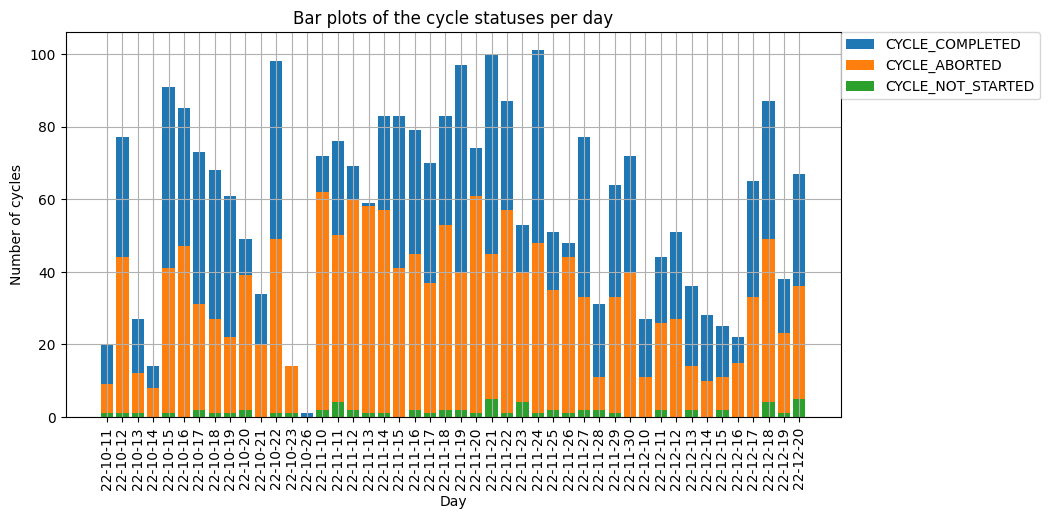

In [51]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [52]:
# label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
# label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
# cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_left = []
# for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
#     statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_left:
#     print(i.shape)
#     print('\n')
# cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_right = []
# for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
#     statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_right:
#     print(i.shape)
#     print('\n')


# cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
# cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
# cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
# for status in status_names:
#     if status not in cycle_statuses_per_day_left.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_left[status] = 0
#     if status not in cycle_statuses_per_day_right.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_right[status] = 0
# print(cycle_statuses_per_day_right)




In [53]:
cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day_left.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_left[status] = 0
    if status not in cycle_statuses_per_day_right.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_right[status] = 0
statuses_per_day_left = []
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_left:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')
statuses_per_day_right = []    
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_right:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

(45, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(45, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(45, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_

3


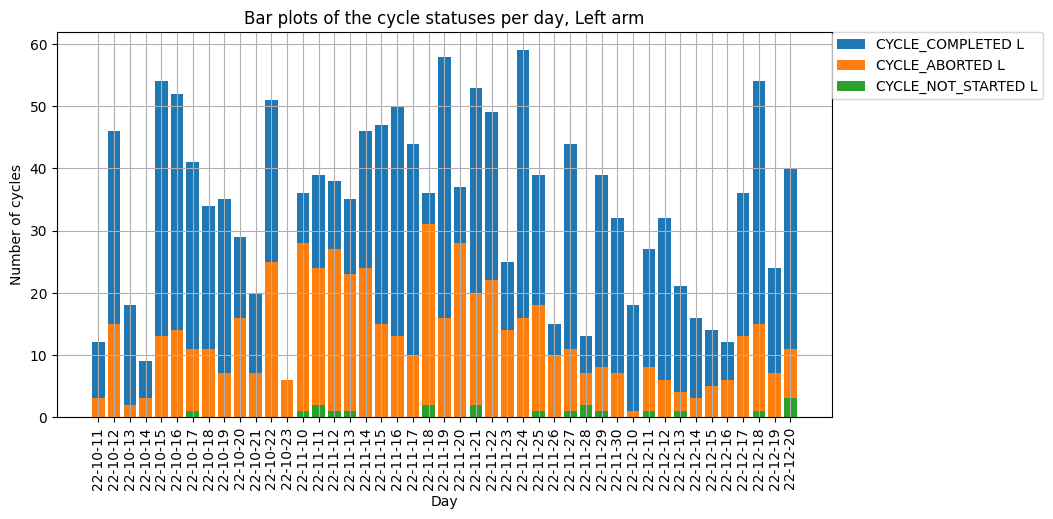

In [54]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

46


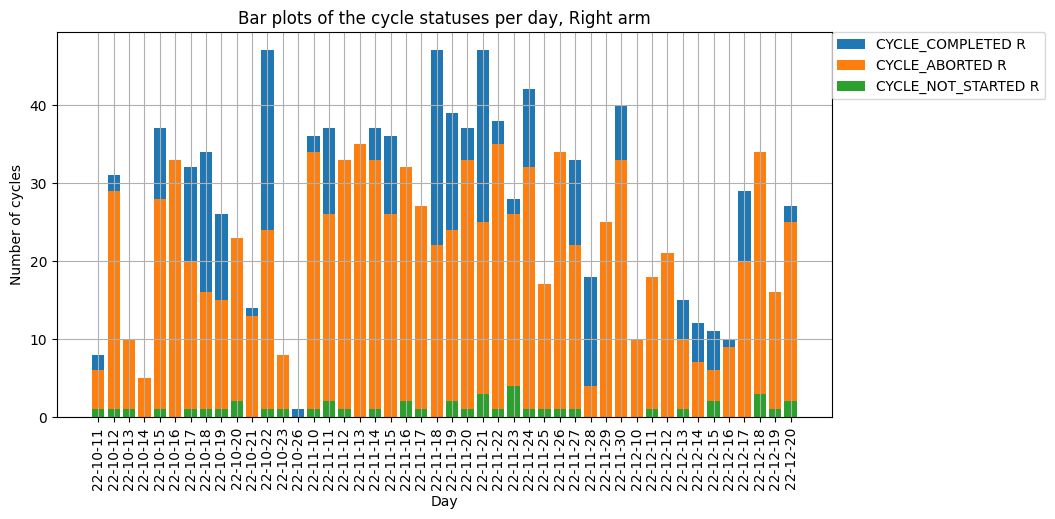

In [55]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [56]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

Index(['y-m-day', 'ddc_ev_timestamp', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')
    y-m-day    ddc_ev_timestamp ddc_mch_side  ddc_barcode                        first                         last             status
0  22-10-11 2022-10-11 00:40:46            R   9439791381              UN_VACUUM_START              UN_VACUUM_START  CYCLE_NOT_STARTED
1  22-10-11 2022-10-11 19:49:39            L   9439791357     LO_LOADER_IN_PRESS_START     LO_LOADER_IN_PRESS_START      CYCLE_ABORTED
2  22-10-11 2022-10-11 19:49:39            R   9439791356     LO_LOADER_IN_PRESS_START     LO_LOADER_IN_PRESS_START      CYCLE_ABORTED
3  22-10-11 2022-10-11 19:49:44            L   9439791357  LO_BLADDER_PRESHAPING_START      LO_LOADER_IN_PRESS_STOP  CYCLE_NOT_STARTED
4  22-10-11 2022-10-11 19:49:44            R   9439791356      LO_LOADER_IN_PRESS_STOP  LO_BLADDER_PRESHAPING_START  CYCLE_NOT_STARTED


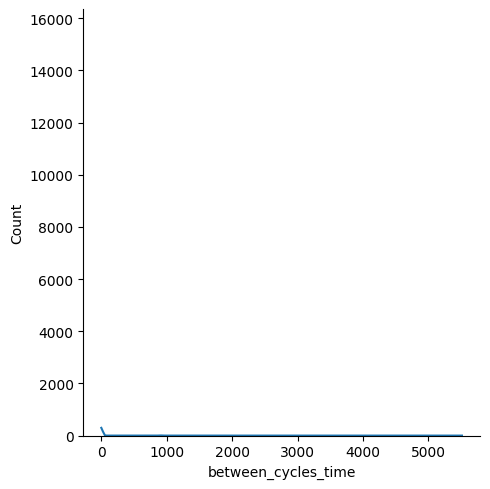

              status       mean  median         std  min     max
0      CYCLE_ABORTED  76.176033     2.0  414.717592  0.0  5514.0
1    CYCLE_COMPLETED   1.480999     1.0   18.345378  1.0   805.0
2  CYCLE_NOT_STARTED  32.830993     4.0  159.562322  0.0  3823.0
              status       mean  median         std  min     max
0      CYCLE_ABORTED  85.392874     1.0  496.552277  0.0  6243.0
1    CYCLE_COMPLETED   1.746914     1.0   12.795828  0.0   384.0
2  CYCLE_NOT_STARTED  32.831133     4.0  161.089133  0.0  5309.0


<Axes: xlabel='status'>

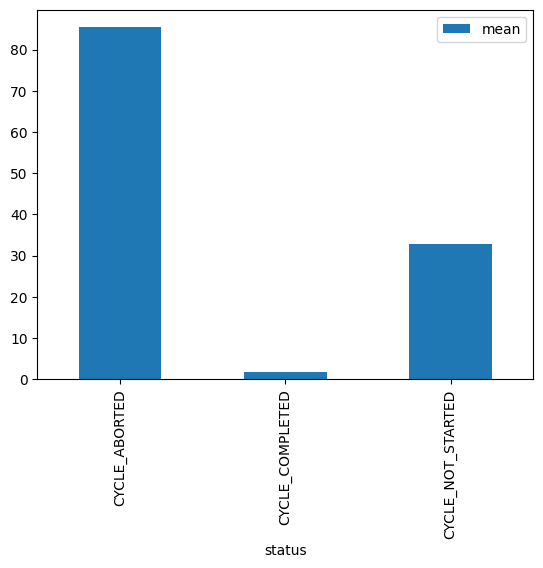

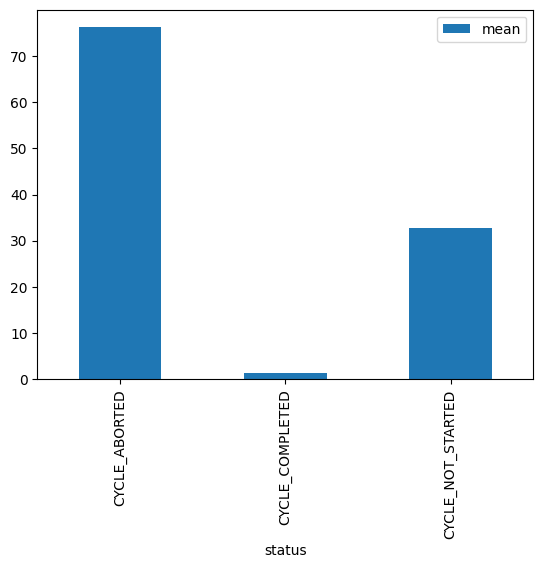

In [57]:
label_cycle_status_for_time = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.time, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status_for_time[ColumnsOutput.status] = False
print(label_cycle_status_for_time.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status_for_time[ColumnsOutput.status] = label_cycle_status_for_time.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status_for_time.value_counts(ColumnsOutput.status)
print(label_cycle_status_for_time.head())
plt.show()

label_cycle_status_for_time_left = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'L']
label_cycle_status_for_time_right = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'R']

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left[ColumnsInput.time].diff().dt.total_seconds()
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right[ColumnsInput.time].diff().dt.total_seconds()

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left['between_cycles_time'].fillna(0)
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right['between_cycles_time'].fillna(0)

z = np.abs(stats.zscore(label_cycle_status_for_time_right['between_cycles_time']))
label_cycle_status_for_time_right = label_cycle_status_for_time_right[(z < 1)]

z = np.abs(stats.zscore(label_cycle_status_for_time_left['between_cycles_time']))
label_cycle_status_for_time_left = label_cycle_status_for_time_left[(z < 1)]

sns.displot(label_cycle_status_for_time_right['between_cycles_time'], kde=True)
plt.show()

label_cycle_status_for_time_right_stats = label_cycle_status_for_time_right.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
label_cycle_status_for_time_left_stats = label_cycle_status_for_time_left.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

print(label_cycle_status_for_time_right_stats)
label_cycle_status_for_time_left_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')
print(label_cycle_status_for_time_left_stats)
label_cycle_status_for_time_right_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')



## Getting all previous indices per day fro the machines

In [58]:

len(days)



46

In [59]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-11,30,15.0,15,83953.0,15020.0,83953.0,12.0,3.0,0.0,8,6,1,20,9,1
1,22-10-12,122,61.0,61,85751.0,85751.0,85751.0,46.0,15.0,0.0,31,29,1,77,44,1
2,22-10-13,40,20.0,20,20496.0,20496.0,20496.0,18.0,2.0,0.0,9,10,1,27,12,1
3,22-10-14,22,12.0,10,12857.0,12857.0,9809.0,9.0,3.0,0.0,5,5,0,14,8,0
4,22-10-15,133,67.0,66,75347.0,75318.0,75347.0,54.0,13.0,0.0,37,28,1,91,41,1
5,22-10-16,132,66.0,66,85691.0,68915.0,85688.0,52.0,14.0,0.0,33,33,0,85,47,0
6,22-10-17,106,53.0,53,86399.0,86399.0,85504.0,41.0,11.0,1.0,32,20,1,73,31,2
7,22-10-18,96,45.0,51,86373.0,86373.0,86372.0,34.0,11.0,0.0,34,16,1,68,27,1
8,22-10-19,84,42.0,42,85538.0,85538.0,85538.0,35.0,7.0,0.0,26,15,1,61,22,1
9,22-10-20,90,45.0,45,53708.0,53685.0,53695.0,29.0,16.0,0.0,20,23,2,49,39,2


<Axes: >

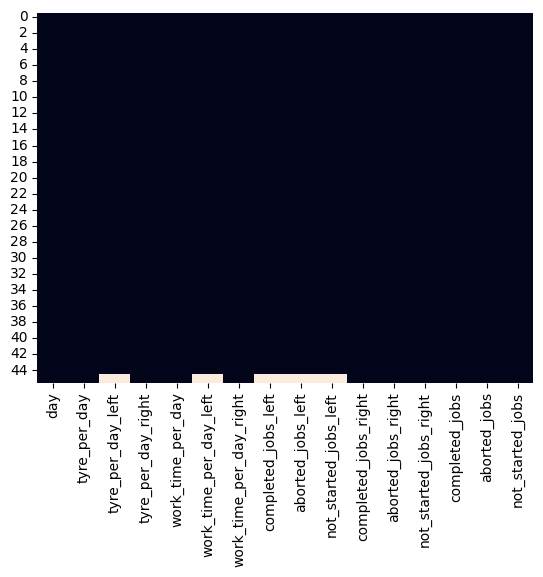

In [60]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

In [61]:
mach_processed_df = mach_processed_df.fillna(0)

### Correlation between the tyres produced and the completed cycles

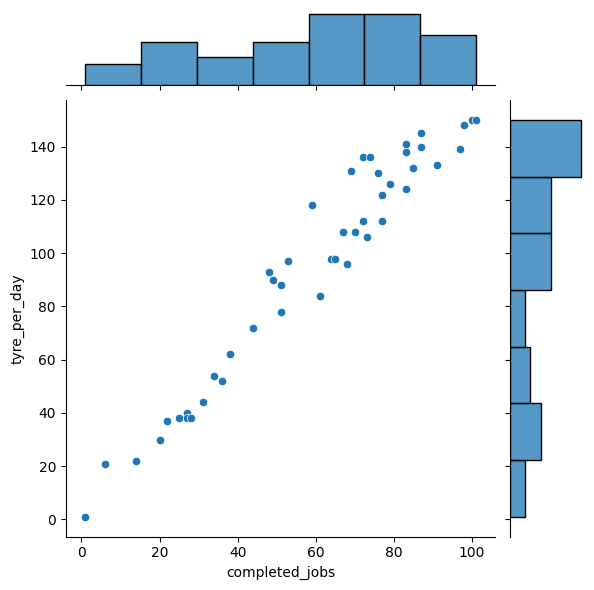

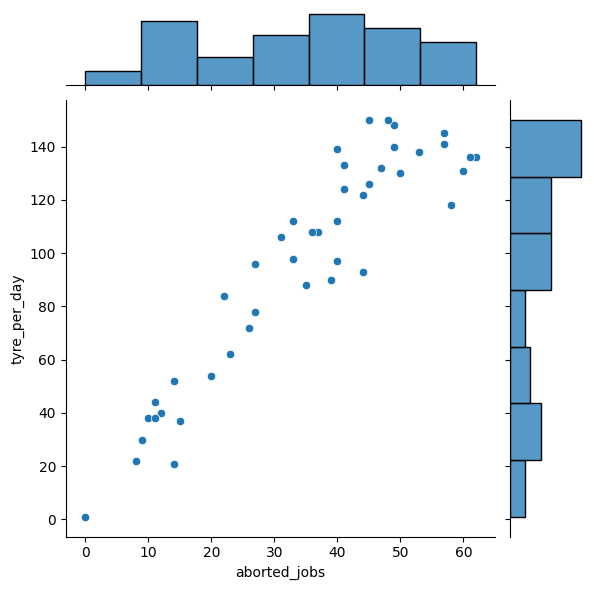

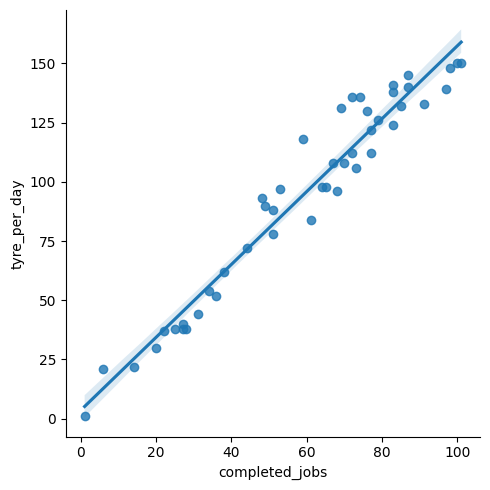

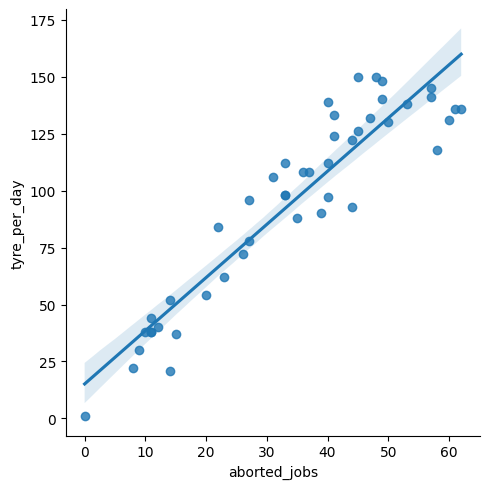

In [62]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

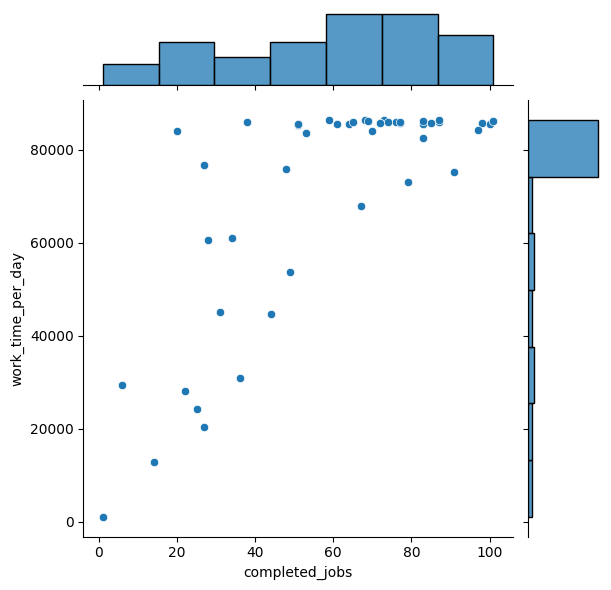

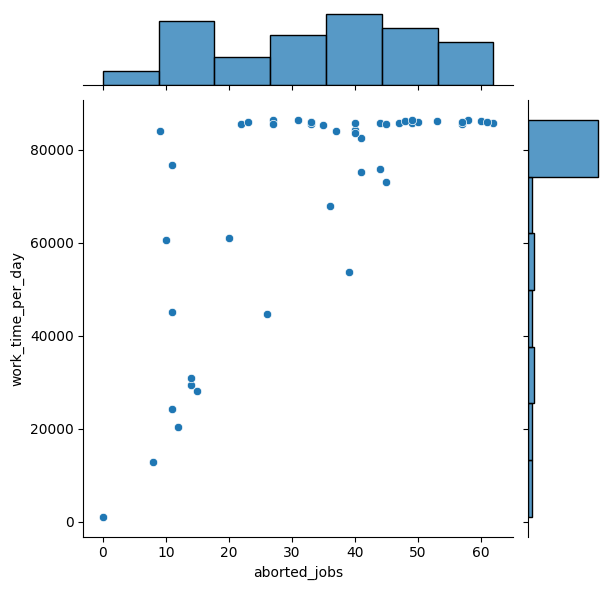

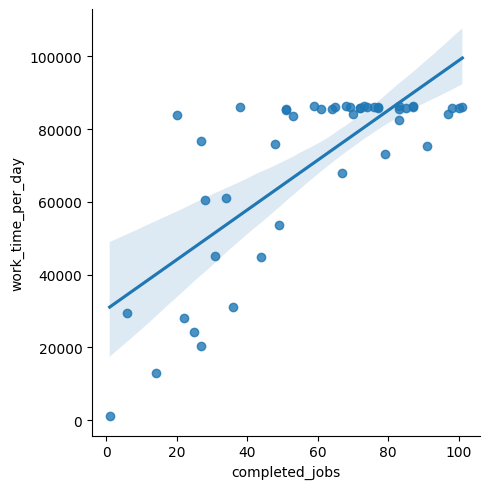

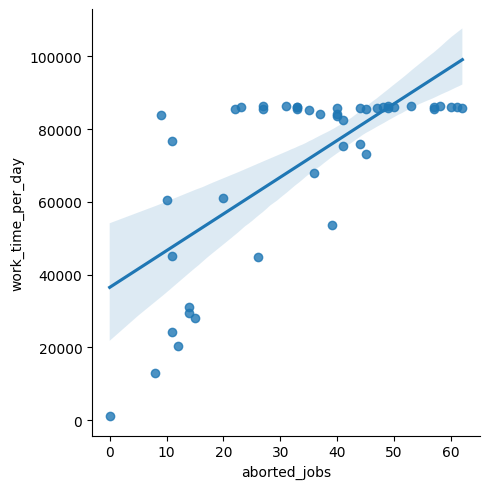

In [63]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

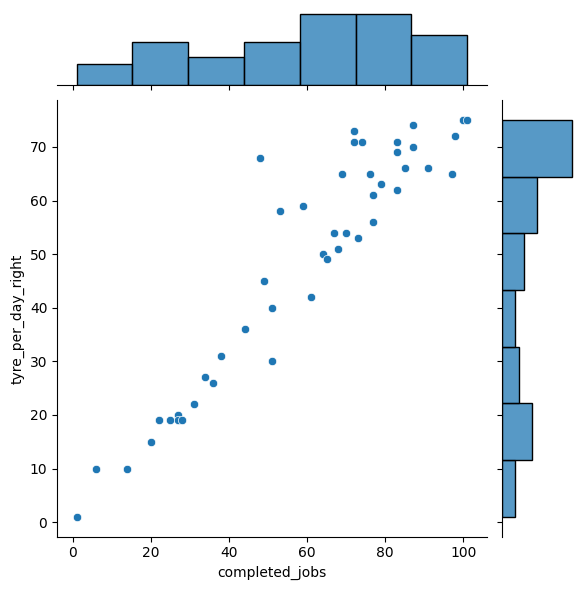

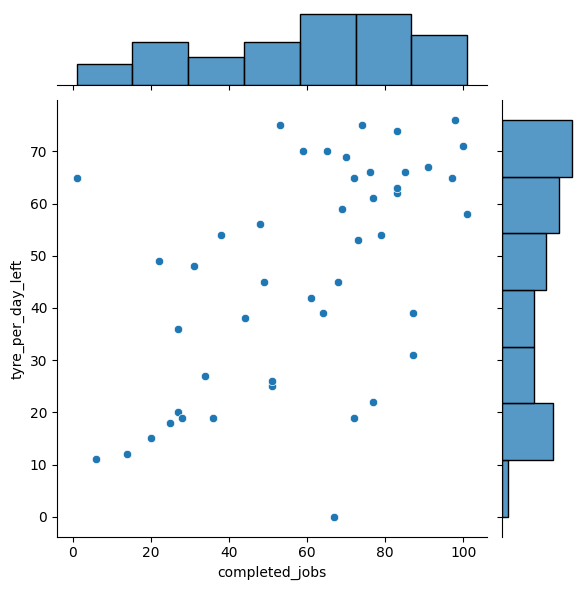

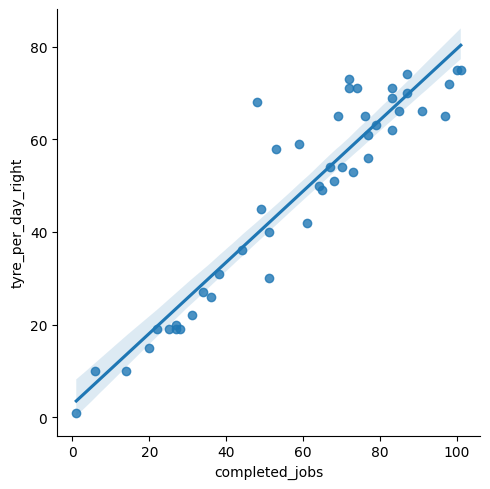

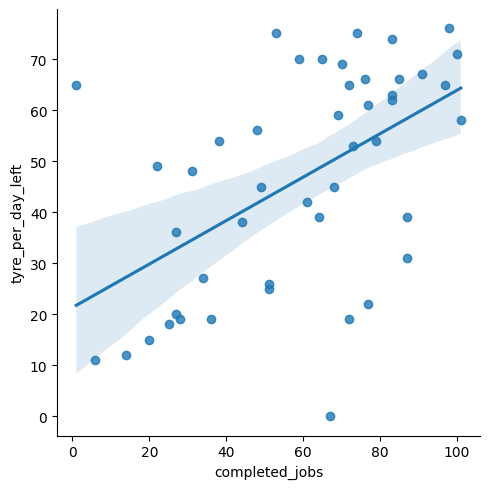

In [64]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

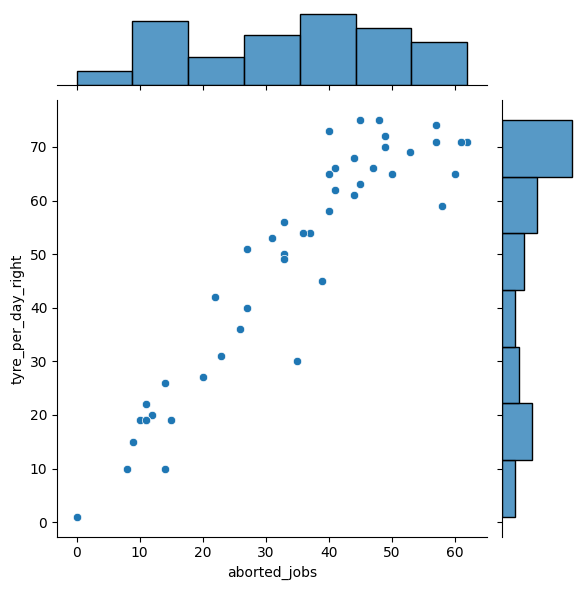

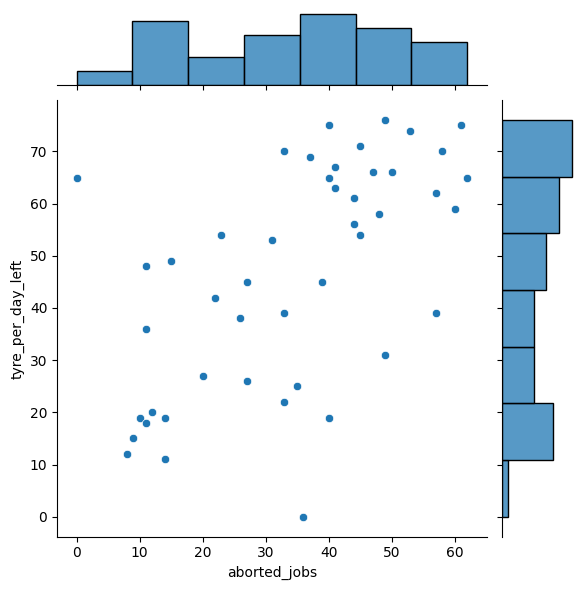

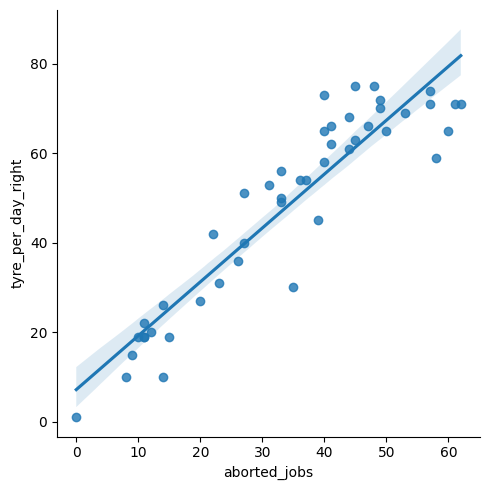

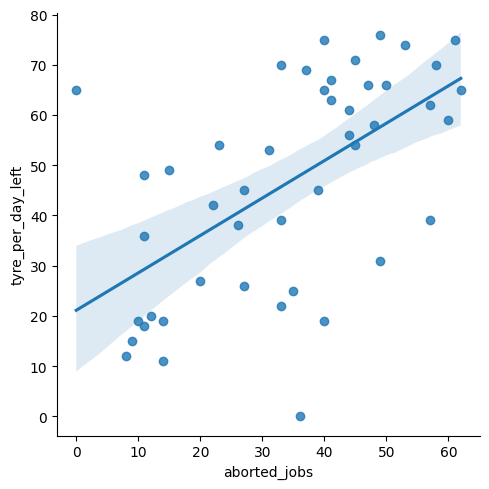

In [65]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


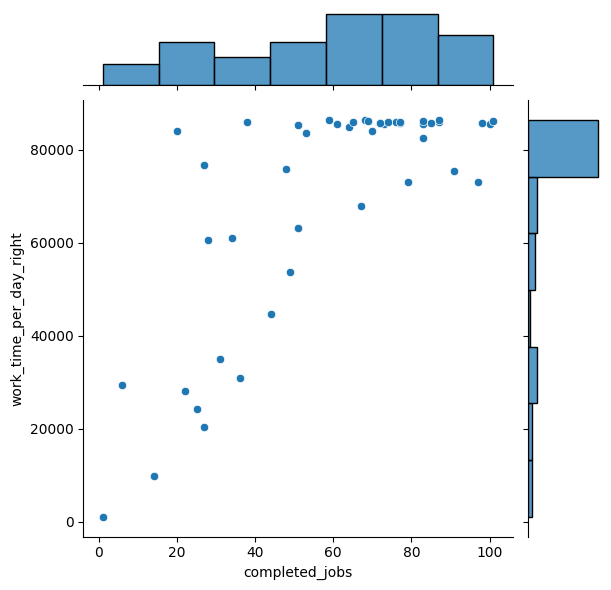

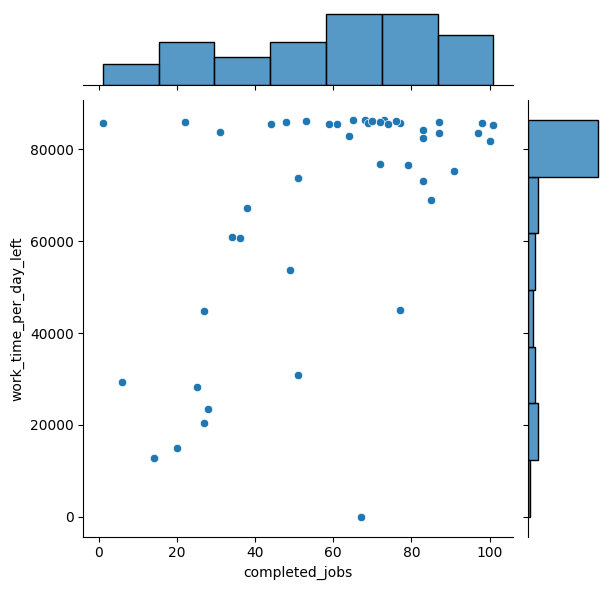

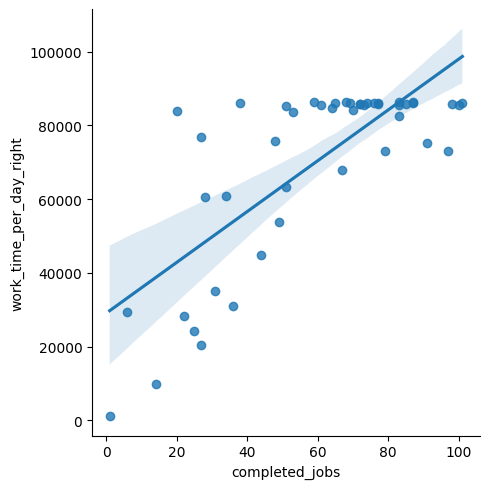

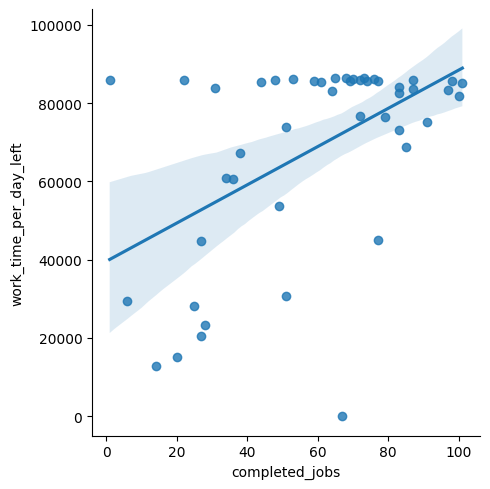

In [66]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

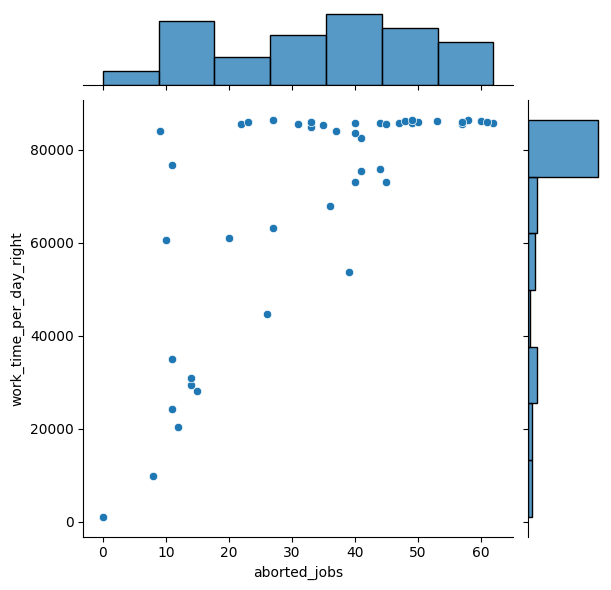

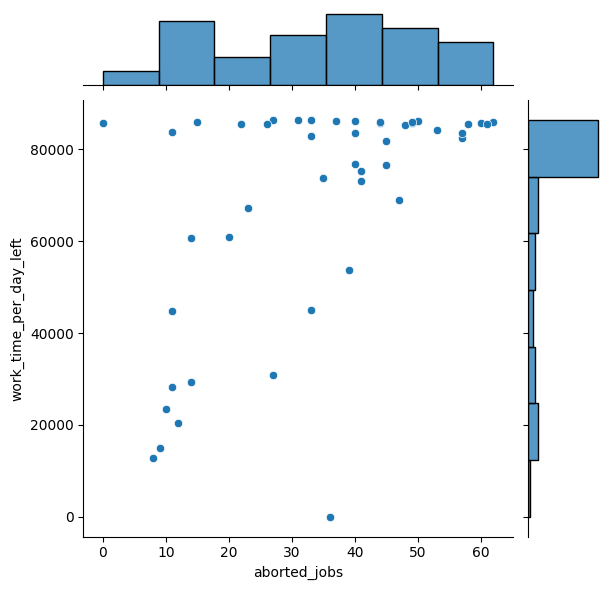

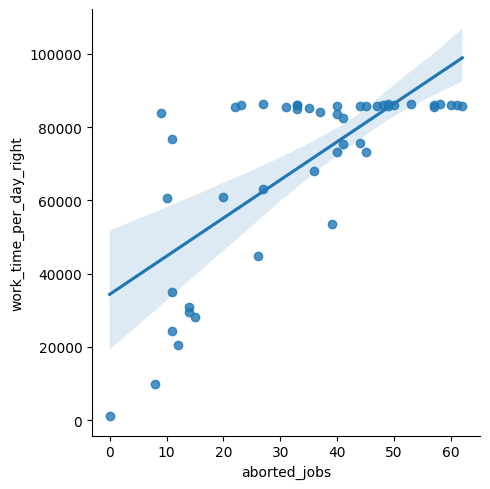

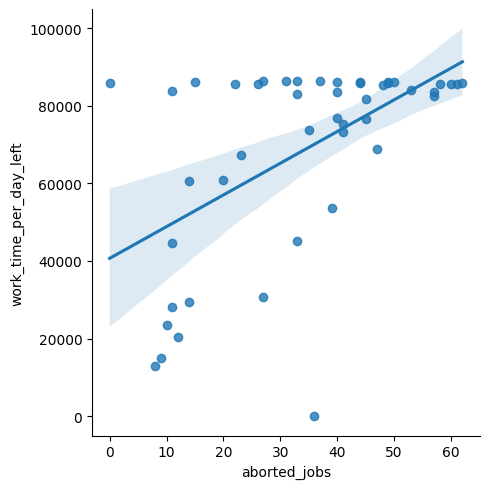

In [67]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)

#### Ideally it should be better to check by arm instead of the enitire miachine at the moment, and apply a regression method to understand the correlation between the barcode processed and the completed cycles

#### fist check the right side

In [68]:
# the data that are more correlated are the tyre per day and the completed jobs.
print(mach_processed_df.columns)

check_corr = mach_processed_df.drop(['day'], axis=1).corr()
check_corr

Index(['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right', 'completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs'], dtype='object')


,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
tyre_per_day,1.000000,0.570987,0.975082,0.766876,0.549680,0.771753,0.549936,0.471977,0.035267,0.939267,0.898688,0.320529,0.973548,0.933062,0.354800
tyre_per_day_left,0.570987,1.000000,0.566275,0.417660,0.780259,0.427658,0.951937,0.829926,0.254101,0.584357,0.481244,0.098099,0.530229,0.585836,0.039644
tyre_per_day_right,0.975082,0.566275,1.000000,0.757070,0.561046,0.764534,0.564460,0.429950,0.056611,0.956133,0.931651,0.316862,0.937929,0.929354,0.325559
work_time_per_day,0.766876,0.417660,0.757070,1.000000,0.418633,0.987247,0.431862,0.272452,0.205324,0.722892,0.714050,0.156802,0.757573,0.705847,0.171587
work_time_per_day_left,0.549680,0.780259,0.561046,0.418633,1.000000,0.438020,0.757046,0.624693,0.152999,0.564166,0.497792,0.069692,0.519549,0.548135,0.056822
work_time_per_day_right,0.771753,0.427658,0.764534,0.987247,0.438020,1.000000,0.441822,0.281630,0.189397,0.725608,0.724833,0.177959,0.755392,0.720398,0.185982
completed_jobs_left,0.549936,0.951937,0.564460,0.431862,0.757046,0.441822,1.000000,0.621166,0.146200,0.592158,0.471056,0.059608,0.525555,0.543756,-0.001807
aborted_jobs_left,0.471977,0.829926,0.429950,0.272452,0.624693,0.281630,0.621166,1.000000,0.305201,0.427705,0.377905,0.156985,0.413264,0.517611,0.114463
not_started_jobs_left,0.035267,0.254101,0.056611,0.205324,0.152999,0.189397,0.146200,0.305201,1.000000,0.033072,0.089692,-0.099451,-0.001226,0.094831,-0.061185
completed_jobs_right,0.939267,0.584357,0.956133,0.722892,0.564166,0.725608,0.592158,0.427705,0.033072,1.000000,0.787283,0.260731,0.945309,0.829070,0.312802


In [69]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def svr_regression(x,y):
    print("Model: SVR")
    model = SVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model 

def grad_boost(x, y):
    print("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
    X_test = scaler.fit_transform(X_test.values.reshape(-1,1))
    y_test = scaler.fit_transform(y_test.values.reshape(-1,1))
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    return model

In [70]:
#split data into train and test
from sklearn.model_selection import train_test_split


right_x = mach_processed_df['tyre_per_day_right']
right_y = mach_processed_df['completed_jobs_right']



left_x = mach_processed_df['tyre_per_day_left']
left_y = mach_processed_df['completed_jobs_left']



model = evaluations(right_x, right_y, lin_regr)
model = evaluations(right_x, right_y, svr_regression)
model = evaluations(right_x, right_y, grad_boost)

model = evaluations(left_x, left_y, lin_regr)
model = evaluations(left_x, left_y, svr_regression)
model = evaluations(left_x, left_y, grad_boost)



Model: Linear Regression
Model score: 0.8902726438645563
Metrics are:
 Accuracy: 0.89645378266321
 MSE: 0.030612380884434087 
 R2: 0.89645378266321


Model: SVR
Model score: 0.8871788732837036
Metrics are:
 Accuracy: 0.9010779725141302
 MSE: 0.02924528641551804 
 R2: 0.9010779725141302


Model: Gradient Boosting
Model score: 0.9905538989646482
Metrics are:
 Accuracy: 0.8475592997481671
 MSE: 0.04506753504302974 
 R2: 0.8475592997481671


Model: Linear Regression
Model score: 0.8883989985842351
Metrics are:
 Accuracy: 0.8855009296160203
 MSE: 0.05932275430618195 
 R2: 0.8855009296160203


Model: SVR
Model score: 0.8922912598403818
Metrics are:
 Accuracy: 0.8912770680561343
 MSE: 0.05633009733200518 
 R2: 0.8912770680561343


Model: Gradient Boosting
Model score: 0.9790516904041189
Metrics are:
 Accuracy: 0.9088911911384551
 MSE: 0.047204099256849034 
 R2: 0.9088911911384551




### On entire machine


In [71]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['completed_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.9341855132904405
Metrics are:
 Accuracy: 0.9519795663688646
 MSE: 0.015952085703825888 
 R2: 0.9519795663688646


Model: SVR
Model score: 0.91079698527353
Metrics are:
 Accuracy: 0.9347151186608292
 MSE: 0.021687226531234723 
 R2: 0.9347151186608292


Model: Gradient Boosting
Model score: 0.9984149470614683
Metrics are:
 Accuracy: 0.8536275635635332
 MSE: 0.04862400178740572 
 R2: 0.8536275635635332




### evaluate the correlation between the aborted jobs and the tyre produced

In [72]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['aborted_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.855710598248526
Metrics are:
 Accuracy: 0.8035209633308014
 MSE: 0.07043192941902623 
 R2: 0.8035209633308014


Model: SVR
Model score: 0.8728986971400561
Metrics are:
 Accuracy: 0.7860922582827862
 MSE: 0.07667960522514074 
 R2: 0.7860922582827862


Model: Gradient Boosting
Model score: 0.9958893367948909
Metrics are:
 Accuracy: 0.4513584789378533
 MSE: 0.19667177497849614 
 R2: 0.4513584789378533


